<a href="https://colab.research.google.com/github/Furatus/4MLUP_Anthem/blob/main/4MLUP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <u>Apprentissage non supervisé - Étude des hymnes nationaux</u>

Ce document est un rapport d'étude des hymnes nationaux dans un contexte d'apprentissage non-supervisé. Il comporte plusieurs parties indispensables à l'analyse des différents hymnes.

On retrouvera (sommaire) :

- Une analyse exploratoire, bien que rapide car notre dataset ne comporte pas beaucoup de variables, on décrira rapidement les données qui nous sont fournies
- Un Patitionnement par K-means
- Un Partitionnement Hiérarchique

---

## Généralités du document | Définition des variables globales

On commence par importer toutes les librairies dont nous aurons besoin lors de cette étude:

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import nltk
from nltk.corpus import stopwords

from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from yellowbrick.text import TSNEVisualizer
from wordcloud import WordCloud
import geopandas as gpd
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

*(Le fichier csv est disponible sur kaggle, ou directement sur ce repository github)*

In [15]:
csvfileurl = "https://raw.githubusercontent.com/Furatus/4MLUP_Anthem/refs/heads/main/anthems.csv"

df_anthem = pd.read_csv(csvfileurl)

---

## Analyse Exploratoire

Notre analyse débute par un description générale du dataset :

In [16]:
df_anthem.info()
df_anthem.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Country    190 non-null    object
 1   Alpha-2    189 non-null    object
 2   Alpha-3    190 non-null    object
 3   Continent  190 non-null    object
 4   Anthem     190 non-null    object
dtypes: object(5)
memory usage: 7.6+ KB


,Country,Alpha-2,Alpha-3,Continent,Anthem
count,190,189,190,190,190
unique,190,188,190,6,188
top,Albania,CH,ALB,Africa,"We knew thee of old, O, divinely restored, By ..."
freq,1,2,1,56,2


On observe qu'il manque uniquement 1 seule valeur parmis tout le dataset, vérifions quel est le pays auquel la valeur manque

In [17]:
df_anthem[df_anthem['Alpha-2'].isna()]

,Country,Alpha-2,Alpha-3,Continent,Anthem
168,Namibia,NaN,NAM,Africa,Namibia land of the brave Freedom fight we he ...


La Namibie n'a pas de code alpha-2 dans ce dataset (Officillement, c'est "NA").

> Mais ce n'est pas grave, car les variables Alpha-2 et Alpha-3 ne nous intéresseront pas dans notre apprentissage ni dans notre analyse, nous allons donc les supprimer pour ne pas parasiter le clustering


In [18]:
df_anthem = df_anthem.drop(columns=['Alpha-2','Alpha-3'])

Le Dataset étant maintenant très limité, l'analyse ne peut se porter que sur une seule variable : le continent.

Passons en revue la variable continent dans un pie chart :

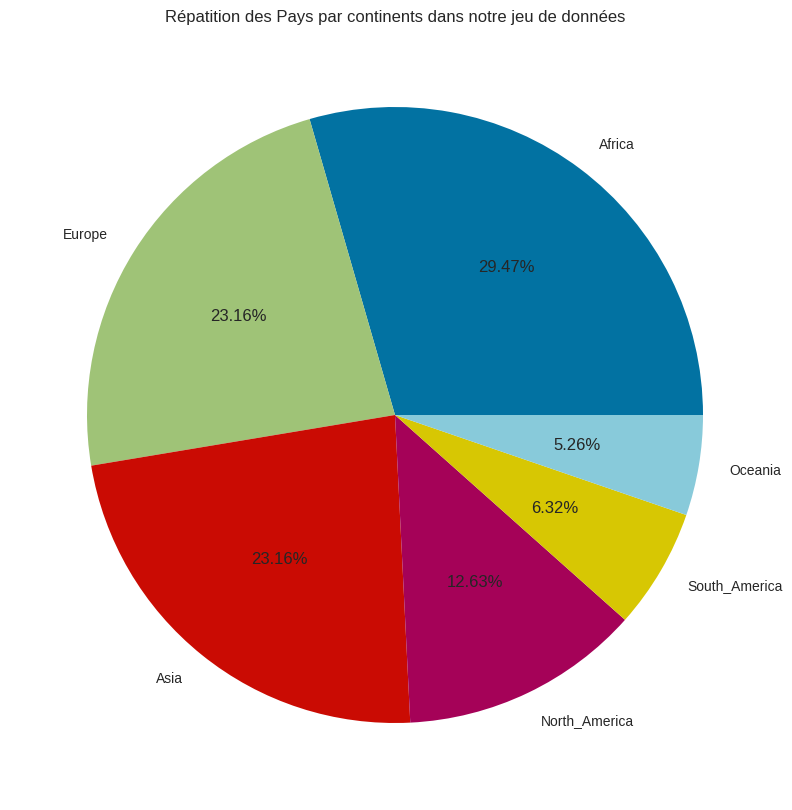

In [19]:
continent_counts = df_anthem['Continent'].value_counts()

plt.figure(figsize=(12,10))
plt.title('Répatition des Pays par continents dans notre jeu de données')
plt.pie(continent_counts, labels= continent_counts.index, autopct= '%.2f%%')
plt.show()


Observations :

- Les Pays d'Afrique, d'Asie et d'Europe sont les plus représentés de notre dataset.

> C'est une observation logique quand on sait que ce sont les continents qui concentrent le plus grand nombre de pays.

Notre analyse exploratoire se termine ici par manque de variables à analyser.

---

## Partitionnement par la méthode des K-Means

Le partitionnement des K-Means commencera par le téléchargement des différentes données nécessaires pour faire fonctionner le librairie nltk :

In [23]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [21]:
def preprocess_text(text):
    # Convertir en minuscules
    text = text.lower()
    # Supprimer la ponctuation
    text = ''.join([char for char in text if char.isalpha() or char.isspace()])
    return text

df_anthem['Anthem'] = df_anthem['Anthem'].apply(preprocess_text)


In [24]:
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    words = nltk.word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

df_anthem['Anthem'] = df_anthem['Anthem'].apply(lemmatize_text)


In [26]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X = tfidf_vectorizer.fit_transform(df_anthem['Anthem'])


In [32]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)
df_anthem['cluster'] = kmeans.labels_


<class 'scipy.sparse._csr.csr_matrix'>


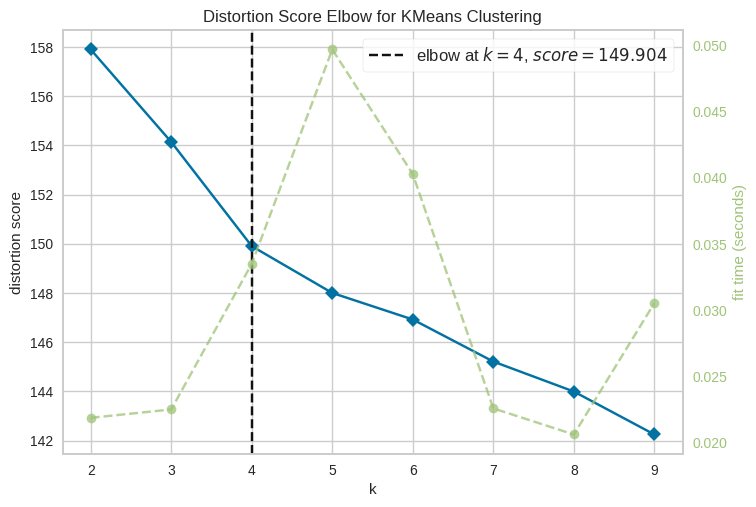

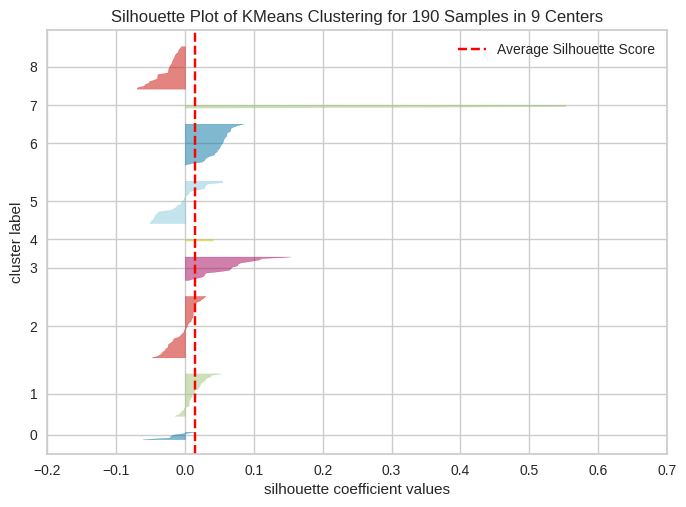

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 190 Samples in 9 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [43]:
print(type(X))

X_Array = X.toarray()

# Méthode du coude
visualizer = KElbowVisualizer(kmeans, k=(2,10))
visualizer.fit(X_Array)
visualizer.show()

# Méthode silhouette
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X_Array)
visualizer.show()


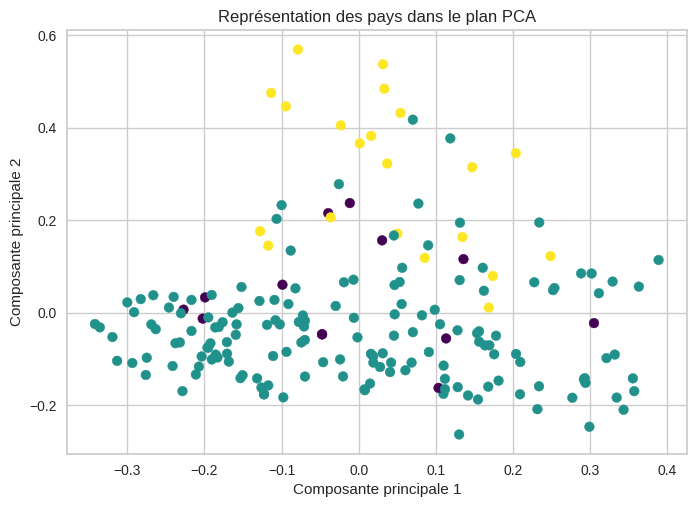

In [45]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_anthem['cluster'], cmap='viridis')
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.title('Représentation des pays dans le plan PCA')
plt.show()


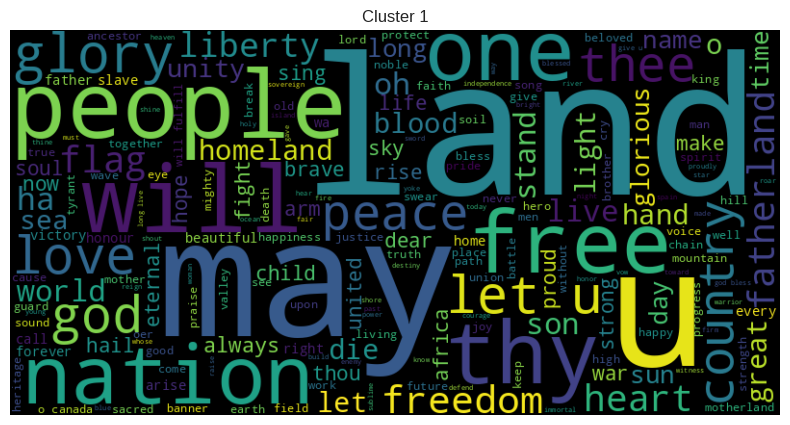

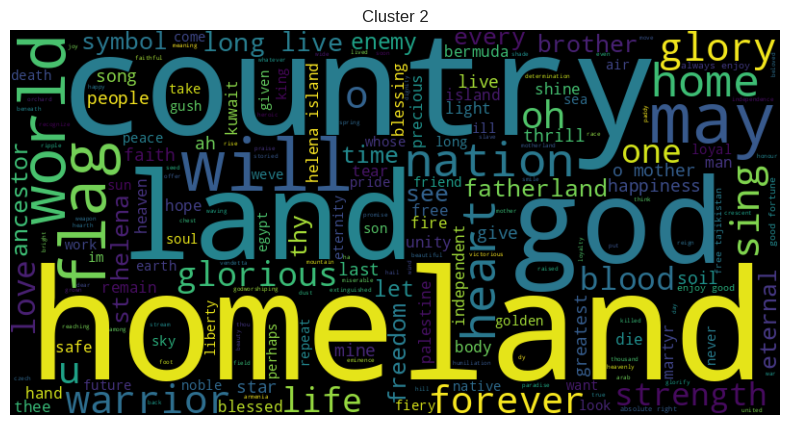

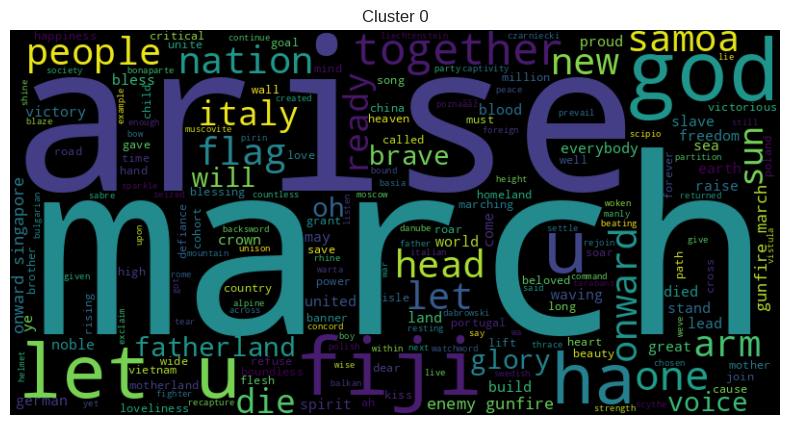

In [48]:
for cluster in df_anthem['cluster'].unique():
    text = ' '.join(df_anthem[df_anthem['cluster'] == cluster]['Anthem'])
    wordcloud = WordCloud(width=800, height=400).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Cluster {cluster}')
    plt.axis('off')
    plt.show()



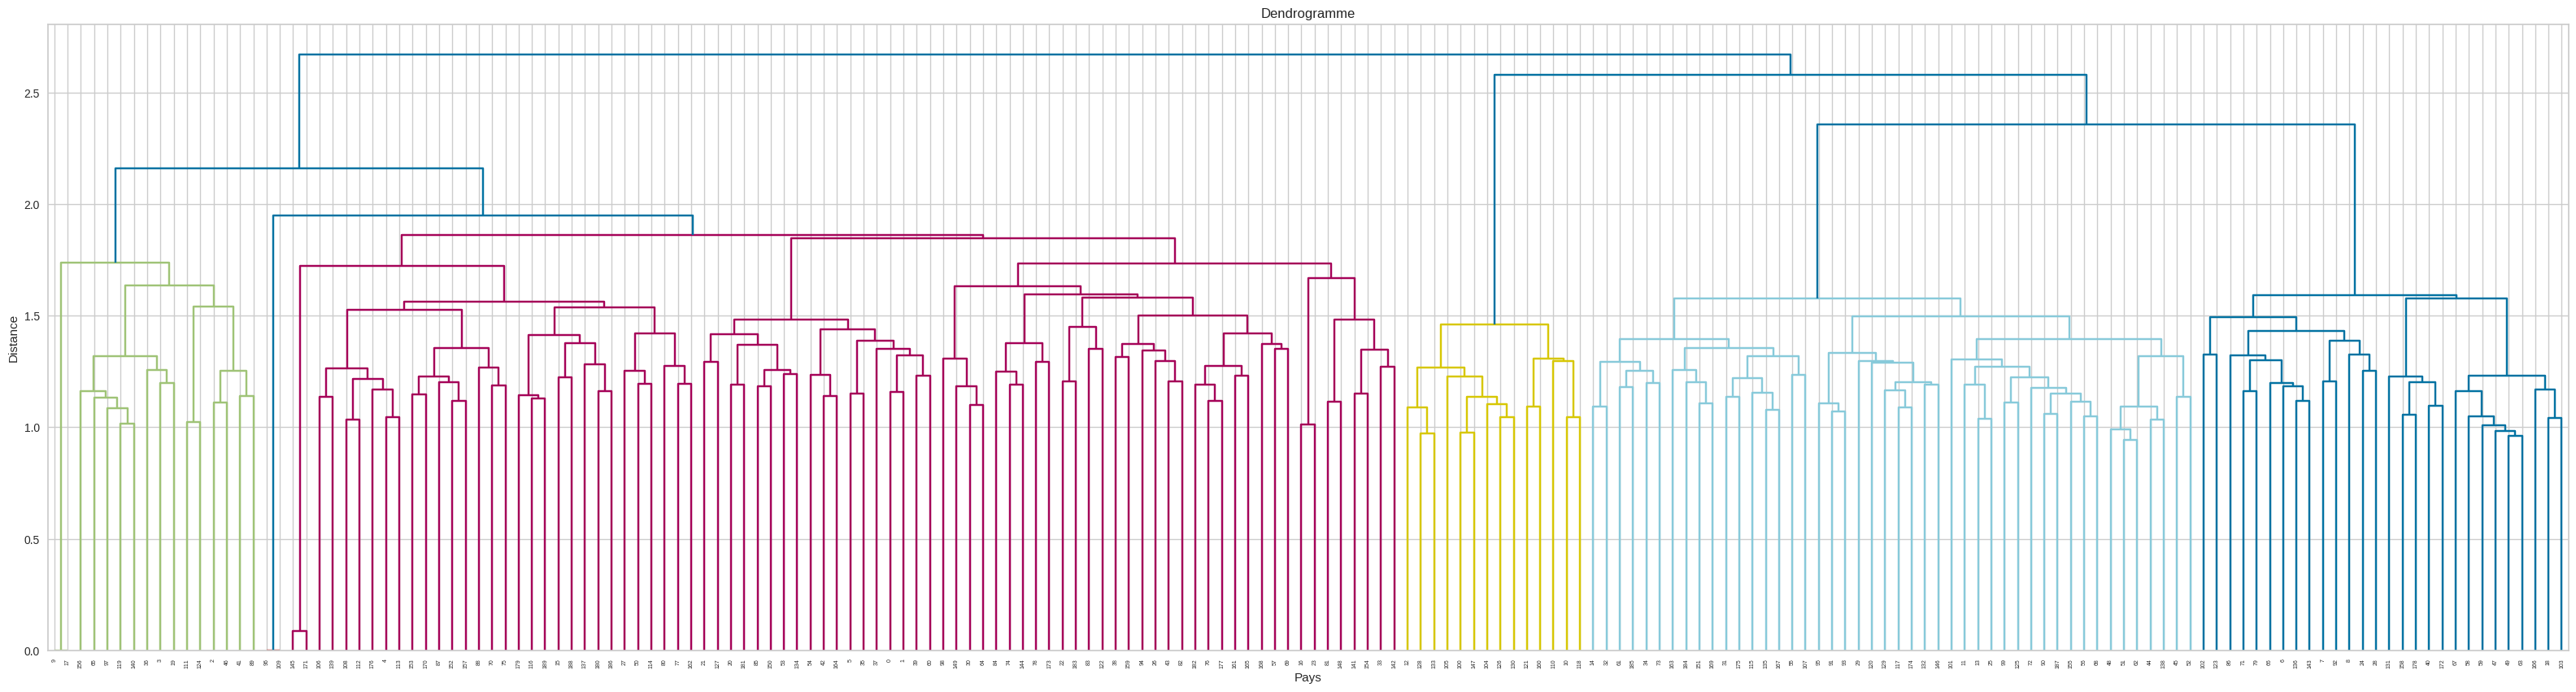

In [51]:
Z = linkage(X.toarray(), method='ward')

plt.figure(figsize=(40, 10))
dendrogram(Z)
plt.title('Dendrogramme')
plt.xlabel('Pays')
plt.ylabel('Distance')
plt.show()
